In [1]:
ROWS=299
COLS=299
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
train_idg = ImageDataGenerator(vertical_flip=True,
                               horizontal_flip=True,
                               height_shift_range=0.1,
                               width_shift_range=0.1,
                               preprocessing_function=preprocess_input)
train_gen = train_idg.flow_from_directory(
    '../input/datatask1/task1/train',
    target_size=(ROWS, COLS),
    batch_size = 64
)
val_datagen = ImageDataGenerator(rescale=1/255)
val_gen = val_datagen.flow_from_directory(
    '../input/datatask1/task1/val',
    target_size=(ROWS, COLS),
    batch_size = 16
)

Found 14465 images belonging to 2 classes.
Found 1808 images belonging to 2 classes.


In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras import applications
import numpy as np

In [3]:

input_shape = (ROWS, COLS, 3)
nclass = len(train_gen.class_indices)

base_model = tf.keras.applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(ROWS, COLS,3))
base_model.trainable = False

add_model = Sequential()
add_model.add(base_model)
add_model.add(tf.keras.layers.Conv2D(64,kernel_size=(3,3)))
add_model.add(BatchNormalization())
add_model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
add_model.add(tf.keras.layers.Conv2D(32,kernel_size=(3,3)))
add_model.add(BatchNormalization())
add_model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(nclass, 
                    activation='softmax'))

model = add_model
metrics = METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precison"),
    tf.keras.metrics.Recall(name="recall")
]
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              metrics=metrics)
model.summary()

2022-04-23 14:01:38.711131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 14:01:38.821994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 14:01:38.823208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 14:01:38.825278: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

87924736/87910968 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 6, 6, 64)          1179712   
_________________________________________________________________
batch_normalization_94 (Batc (None, 6, 6, 64)          256       
_________________________________________________________________
activation_94 (Activation)   (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 4, 4, 32)          18464     
_________________________________________________________________
batch_normalization_95 (Batc (None, 4, 4, 32)          128       
_________________________________________________________

In [4]:
import tensorflow.keras as keras
file_path="weights.best.hdf5"

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = keras.callbacks.ModelCheckpoint('best_model_alt-loss.h5', monitor='loss', mode='min', save_best_only=True)
ms = keras.callbacks.ModelCheckpoint('best_model_alt-valloss.h5', monitor='val_loss', mode='min', save_best_only=True)

callbacks_list = [es, mc,ms] #early
with tf.device('/gpu:0'):
    history = model.fit_generator(train_gen,
                              validation_data=val_gen, 
                              epochs=50, 
                              shuffle=True, 
                              verbose=True,
                              callbacks=callbacks_list)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-04-23 14:01:55.584305: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-04-23 14:02:03.940924: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


204/227 [=========================>....] - ETA: 46s - loss: 0.5977 - accuracy: 0.6985 - precison: 0.6985 - recall: 0.6985

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


227/227 [==============================] - 501s 2s/step - loss: 0.5890 - accuracy: 0.7055 - precison: 0.7055 - recall: 0.7055 - val_loss: 0.4825 - val_accuracy: 0.7677 - val_precison: 0.7677 - val_recall: 0.7677
Epoch 2/50
227/227 [==============================] - 434s 2s/step - loss: 0.5138 - accuracy: 0.7602 - precison: 0.7602 - recall: 0.7602 - val_loss: 0.4682 - val_accuracy: 0.7743 - val_precison: 0.7743 - val_recall: 0.7743
Epoch 3/50
227/227 [==============================] - 435s 2s/step - loss: 0.4962 - accuracy: 0.7734 - precison: 0.7734 - recall: 0.7734 - val_loss: 0.4553 - val_accuracy: 0.7887 - val_precison: 0.7887 - val_recall: 0.7887
Epoch 4/50
227/227 [==============================] - 429s 2s/step - loss: 0.4795 - accuracy: 0.7817 - precison: 0.7817 - recall: 0.7817 - val_loss: 0.4531 - val_accuracy: 0.7777 - val_precison: 0.7777 - val_recall: 0.7777
Epoch 5/50
227/227 [==============================] - 429s 2s/step - loss: 0.4696 - accuracy: 0.7857 - precison: 0.7857

Load model

In [9]:
savemodel = tf.keras.models.load_model('./best_model_alt-valloss.h5')

In [10]:
import os
from keras.applications.inception_v3 import preprocess_input
predicted=[]
real=[]
for dir in os.listdir("../input/datatask1/task1/test"):
    if dir=='informative':
        r=0
    else:
        r=1
    for path in os.listdir(f'../input/datatask1/task1/test/{dir}'):
        p=f'../input/datatask1/task1/test/{dir}/{path}'
        img = tf.keras.utils.load_img(
    p, target_size=(299, 299)
)
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        img_array=preprocess_input(img_array)

        predictions = savemodel.predict(img_array)
        real.append(r)
        predicted.append(np.argmax(predictions))

    
#score = tf.nn.softmax(predictions[0])

In [11]:
from sklearn import metrics
print(metrics.classification_report(real,predicted))
print(metrics.confusion_matrix(real,predicted))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       923
           1       0.80      0.84      0.82       886

    accuracy                           0.82      1809
   macro avg       0.82      0.82      0.82      1809
weighted avg       0.82      0.82      0.82      1809

[[742 181]
 [143 743]]


In [ ]:
model.save('InceptionV3 final.h5')

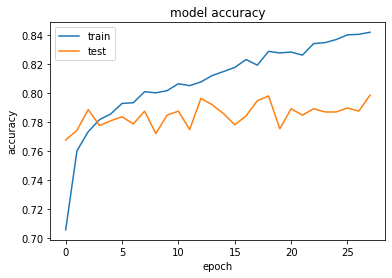

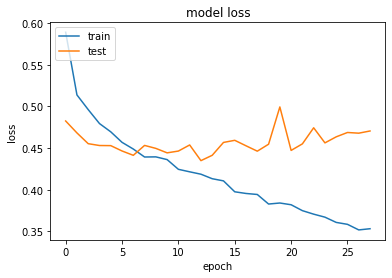

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [1]:
print('abc')

abc
